# Spectrogram preprocessing in different Models & Scenarios

We tried this with a Spectrogram Callback first to extract Preprocessing and Raw Tensors directly from the Pipeline but it was impossible to match the raw Tensors between different models even though `shuffle=False`,`num_workers=1`, `batch_size=1`, and all `augmentations` were off...
So now we do it in an isolated Notebook which makes it easier but Pipeline Preprocessing might not be exactly the same

## Datamodules

### BEANS

In [1]:
from biofoundation.datamodule.beans_datamodule import BEANSDataModule
from birdset.datamodule.base_datamodule import DatasetConfig

def load_beans_dataset(n_classes, sample_rate, name):
    """
    Load the BEANS dataset.
    """
    datasetconfig = DatasetConfig(
        dataset_name=name,
        hf_path=f"DBD-research-group/{name}",
        hf_name="default",
        data_dir="../../../data_birdset",
        n_classes=n_classes,
        sample_rate=sample_rate
    )

    beans_datamodule = BEANSDataModule(dataset=datasetconfig)
    beans_dataset = beans_datamodule._load_data()
    beans_dataset = beans_datamodule._preprocess_data(beans_dataset)
    beans_dataset = beans_datamodule._create_splits(beans_dataset)
    return beans_dataset

/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### BirdSet

In [2]:
from birdset.datamodule import DatasetConfig
from birdset.datamodule.birdset_datamodule import BirdSetDataModule
from datasets import Audio, load_from_disk
import os 

def load_birdset_dataset(sample_rate, name, split="test"):
    """
    Load the BirdSet dataset.
    """
    # Define the dataset configuration
    datasetconfig = DatasetConfig(
        hf_name=name,
        hf_path="DBD-research-group/BirdSet",
        data_dir=f"../../../data_birdset/{name}",
        sample_rate=sample_rate,
        n_workers=3,
        val_split=0.2,
        task="multilabel",
        classlimit=500,
        eventlimit=5,
    )

    birdset_datamodule = BirdSetDataModule(dataset=datasetconfig)
    birdset_datamodule.prepare_data()
    dataset = load_from_disk(os.path.join(birdset_datamodule.disk_save_path, split))
    dataset = dataset.cast_column("filepath", Audio(sampling_rate=sample_rate))

    return dataset

## Load models and loop

In [3]:
import torch
import numpy as np

def convert(inputs, sample_rate=16000, length=10, birdset=False):
    """
    Convert the input to a tensor and 1 batch
    """
    # Get the audio array
    if birdset:
        audio = inputs["filepath"]["array"]
    else:
        audio = inputs["audio"]["array"]
    target_length = sample_rate * length
    # If audio is longer, cut from the end
    if len(audio) > target_length:
        audio = audio[-target_length:]
    # If audio is shorter, pad at the beginning
    elif len(audio) < target_length:
        pad = target_length - len(audio)
        audio = np.pad(audio, (pad, 0), mode="constant")
    return torch.tensor(audio, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

In [4]:
from omegaconf import OmegaConf
from hydra.utils import instantiate

model_cfg = OmegaConf.create({
    "_target_": "biofoundation.modules.models.convnext.ConvNextModule",
    "num_classes": 0,
    "num_channels": 1,
    "checkpoint": "DBD-research-group/ConvNeXT-Base-BirdSet-XCL",
    "local_checkpoint": None,
    "classifier": None,
    "preprocess_in_model": False,
    "pooling": "default",
    "pretrain_info": {
        "hf_path": None,   # you can set these if needed
        "hf_name": None,
        "hf_pretrain_name": None,
        "valid_test_only": False
    }
})
convnext = instantiate(model_cfg)

/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at DBD-research-group/ConvNeXT-Base-BirdSet-XCL were not used when initializing ConvNextForImageClassification: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ConvNextForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ConvNextForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceC

In [ ]:
from biofoundation.modules.models.audiomae import AudioMAEModel
from biofoundation.modules.models.vit_inatsound import Vit_iNatSoundModel
from biofoundation.modules.models.protoCLR import ProtoCLRModel
from tqdm import tqdm
#
# ConvNext_bs, BEATs_NLM, Test PER 

models = [(AudioMAEModel(num_classes=None), 16000), (Vit_iNatSoundModel(num_classes=None), 22_050), (convnext, 32_000)]  # (Model, Sample Rate)
beans_datasets = [("beans_dogs", 10)]  # (Dataset Name, Number of Classes)
birdset_datasets = ["HSN"]
start_samples = 3 # From Dataset i to start
num_samples = 3  # Number of samples to process from each dataset
spectrograms = {}

for model, sample_rate in tqdm(models, desc="Models"):
    # Load beans datasets
    for beans_name, n_classes in beans_datasets:
        beans_dataset = load_beans_dataset(n_classes=n_classes, sample_rate=sample_rate, name=beans_name)
        for i in range(start_samples, start_samples + num_samples):
            input_tensor = convert(beans_dataset["test"][i], sample_rate=sample_rate)
            output = model._preprocess(input_values=input_tensor)
            var_name = f"{model.__class__.__name__}_{beans_name}_{i}"
            spectrograms[var_name] = output
    # Load birdset datasets
    for birdset_name in birdset_datasets:
        birdset_dataset = load_birdset_dataset(sample_rate=sample_rate, name=birdset_name)
        for i in range(start_samples, start_samples + num_samples):
            input_tensor = convert(birdset_dataset[i], sample_rate=sample_rate, birdset=True)
            output = model._preprocess(input_values=input_tensor)
            var_name = f"{model.__class__.__name__}_{birdset_name}_{i}"
            spectrograms[var_name] = output

spectrograms

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/projects/biofoundation/modules/models/ProtoCLR/config.json'

## Plot Spectrograms

3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel
3D tensor detected, extracting first channel


TypeError: Invalid shape (320000,) for image data

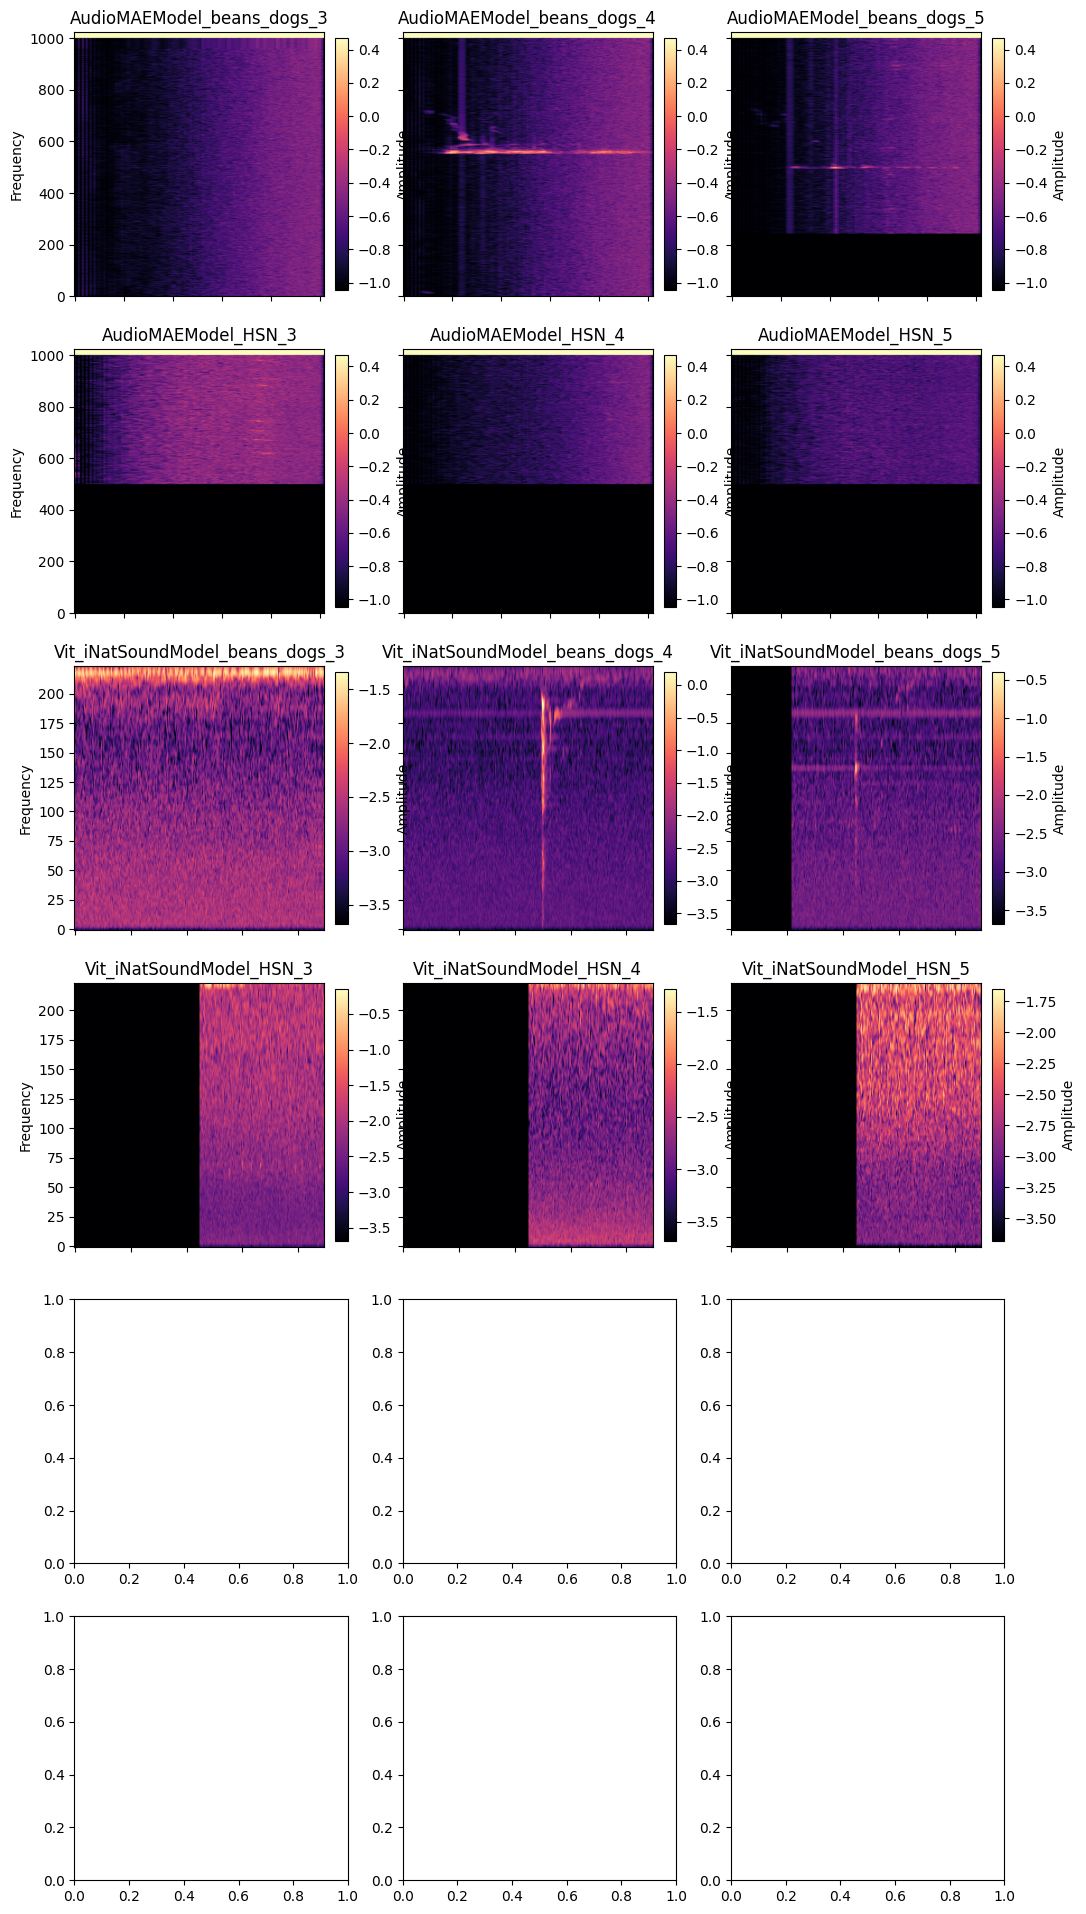

In [38]:
import matplotlib.pyplot as plt

n = len(spectrograms)
cols = num_samples
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))

for ax, (key, spec) in zip(axes.flat, spectrograms.items()):
    img = spec.squeeze().cpu().numpy()
    if img.ndim == 3:
        print("3D tensor detected, extracting first channel")
        img = img[0]
    im = ax.imshow(img, aspect='auto', origin='lower', cmap='magma')
    ax.set_title(key)
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.label_outer()
    # Add colorbar for each subplot
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Amplitude')

# Hide any unused subplots
for i in range(n, rows * cols):
    fig.delaxes(axes.flat[i])

plt.tight_layout()
plt.show()